In [1]:
# This notebook is intended for retirement modeling.

import math
import matplotlib.pyplot as plt
import numpy as np
import plotting
import scipy as scipy
import simulation as sim
from ipywidgets import *

# Plot the figures inline and not in a pop-up
%matplotlib inline

In [53]:
START_YEAR = 2020
END_YEAR = 2060
RETIREMENT_YEAR = 2030

NUM_SIMULATIONS = 1000
THRESHOLD = 0.0

INITIAL_ASSET_VALUE = 400000.0
PAYMENTS = [
    #                     name,                      sum,  change,  stdev,  start_year,           end_year
    sim.recurring_payment('salary',                50000,    1.02,   0.05,  START_YEAR,           RETIREMENT_YEAR),
    sim.recurring_payment('social_security',       25000,    1.02,   0.02,  RETIREMENT_YEAR,      END_YEAR),
    sim.recurring_payment('pension',               15000,    1.02,   0.02,  RETIREMENT_YEAR + 2,  END_YEAR),
    sim.recurring_payment('expenses_working',     -25000,    1.03,   0.15,  START_YEAR,           RETIREMENT_YEAR),
    sim.recurring_payment('expenses_retirement',  -20000,    1.10,   0.10,  RETIREMENT_YEAR,      END_YEAR),
]

In [54]:
def graph_update(rate_of_return, rate_of_return_stddev):

    annual_rate_of_return = sim.simulated_parameter(
        'annual_rate_of_return',
        rate_of_return,
        rate_of_return_stddev,
        START_YEAR,
        END_YEAR
    )
    annual_rate_of_return_ni = sim.simulated_parameter(
        'annual_rate_of_return',
        1.0,
        0.01,
        START_YEAR,
        END_YEAR
    )

    values, incomes = sim.simulate_portfolio(
        INITIAL_ASSET_VALUE,
        annual_rate_of_return,
        PAYMENTS,
        START_YEAR,
        END_YEAR,
        NUM_SIMULATIONS)
    values_ni, incomes_ni = sim.simulate_portfolio(
        INITIAL_ASSET_VALUE,
        annual_rate_of_return_ni,
        PAYMENTS,
        START_YEAR,
        END_YEAR,
        NUM_SIMULATIONS)

    years = range(START_YEAR, END_YEAR + 1, 1)
    
    # Plot of the expected annual income per year.
    plotting.plot_ci(years, incomes, 'Year', 'Income [$]', 'Income', START_YEAR, END_YEAR)
    
    # Plot of the expected portfolio value by year.
    plotting.plot_two_ci(years, values, values_ni, 'Year', 'Value [$]', 'Portfolio Value', START_YEAR, END_YEAR)
    
    # Plot the expected dates for reaching a certain portfolio value.
    dates = plotting.get_crossing_dates(values, years, THRESHOLD)
    dates.sort()
    mean_dates = np.mean(dates)
    print("median crossing, with investment: ", int(math.floor(mean_dates)))
    dates_ni = plotting.get_crossing_dates(values_ni, years, THRESHOLD)
    dates_ni.sort()
    mean_dates_ni = np.mean(dates_ni)
    print("median crossing, no investment: ", int(math.floor(mean_dates_ni)))

    if len(dates) > 0 and len(dates_ni) > 0:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.hist(dates, bins=years, histtype='bar', facecolor='g', alpha=0.2, range=(years[0], years[-1]))
        ax.hist(dates_ni, bins=years, histtype='bar', facecolor='b', alpha=0.4, range=(years[0], years[-1]))
        ax.set(xlabel='Year', ylabel='Num Simulations', title='Year to reach $%2.1f' % THRESHOLD)
    else:
        print("one or more threshold histograms are empty.")

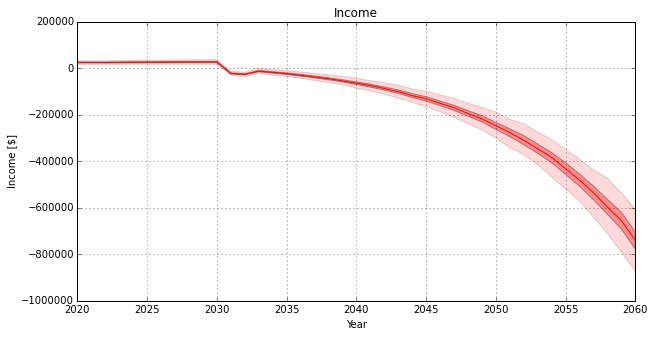

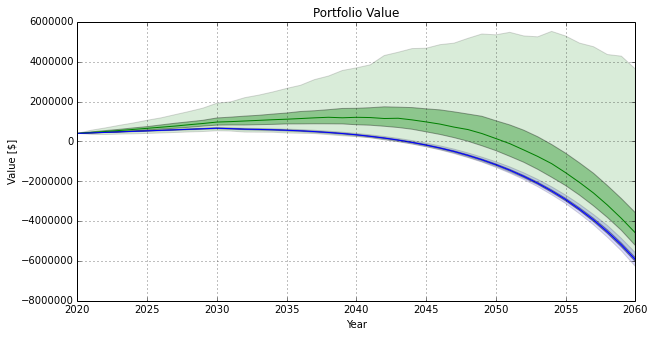

('median crossing, with investment: ', 2049)
('median crossing, no investment: ', 2043)


<function __main__.graph_update>

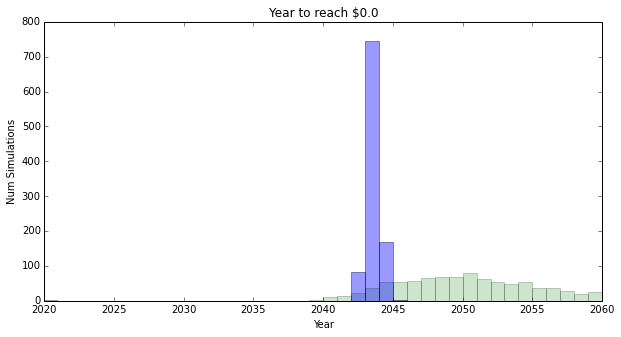

In [55]:
interact(
    graph_update,
    rate_of_return=widgets.FloatSlider(
        value=1.06,
        min=0.8,
        max=1.2,
        step=0.01),
    rate_of_return_stddev=widgets.FloatSlider(
        value=0.15,
        min=0.000001,
        max=0.2,
        step=0.01))